In [10]:
# Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle as pkl
from matplotlib.ticker import (LogLocator)
from IPython.display import HTML
mpl.rcParams.update({'font.size': 14})

In [11]:
filename = 'sherpa_55_trial_id_2'

# Load PINN outputs
with open('pickles/pinn_loss_' + filename + '.pkl', 'rb') as file:
    pinn_loss = pkl.load(file)
    
with open('pickles/boundary_loss_' + filename + '.pkl', 'rb') as file:
    boundary_loss = pkl.load(file)
    
with open('pickles/predictions_' + filename + '.pkl', 'rb') as file:
    predictions = pkl.load(file)
    
with open('pickles/f_boundary.pkl', 'rb') as file:
    f_boundary = pkl.load(file)
    
with open('pickles/p.pkl', 'rb') as file:
    p = pkl.load(file)
    
with open('pickles/T.pkl', 'rb') as file:
    T = pkl.load(file)
    
with open('pickles/r.pkl', 'rb') as file:
    r = pkl.load(file)

In [12]:
# Get properties
size = int(np.sqrt(predictions.shape[0]))
epochs = int(predictions.shape[2])

# Take out of logspace
f_boundary = np.exp(f_boundary)
p = np.exp(p)
T = np.exp(T)
r = np.exp(r)
predictions = np.exp(predictions)

final_predict = predictions[:, :, -1].reshape((size, size))
# final_predict = np.exp(final_predict)

# Check data
print(f'F_boundary shape: {f_boundary.shape}, max: {np.max(f_boundary)}')
print(f'Predictions shape: {predictions.shape}, max: {np.max(predictions[:, :, -1].reshape((size, size))[-1, :-1])}')
print(f'Final_predict shape: {final_predict.shape}, max: {np.max(final_predict[-1, :-1])}')

F_boundary shape: (512, 1), max: 643.4857747295018
Predictions shape: (262144, 1, 100), max: 500.2709639116135
Final_predict shape: (512, 512), max: 500.2709639116135


In [13]:
m = 0.938 # GeV/c^2

# Initialize J
J = np.zeros((size, size))
J_boundary = (f_boundary*(p**2))[:, 0]

# Define phi
def phi_func(r):
    k_0 = 1e11
    func = np.log((120*150e6)/r)*((150e6*400)/(3*k_0))
    return func

# For each r, get phi
for i in range(size):
    phi = phi_func(r[i])
    
    # for each T, calculate J[r, T]
    for j in range(size):
        where_phi = np.argmin(np.abs(T[:, 0] - (T[j, 0] + phi)))
        J[i, j] = ((T[j, 0]*(T[j, 0]+2*m))/((T[j, 0]+phi)*(T[j, 0]+phi+2*m))) * J_boundary[where_phi]

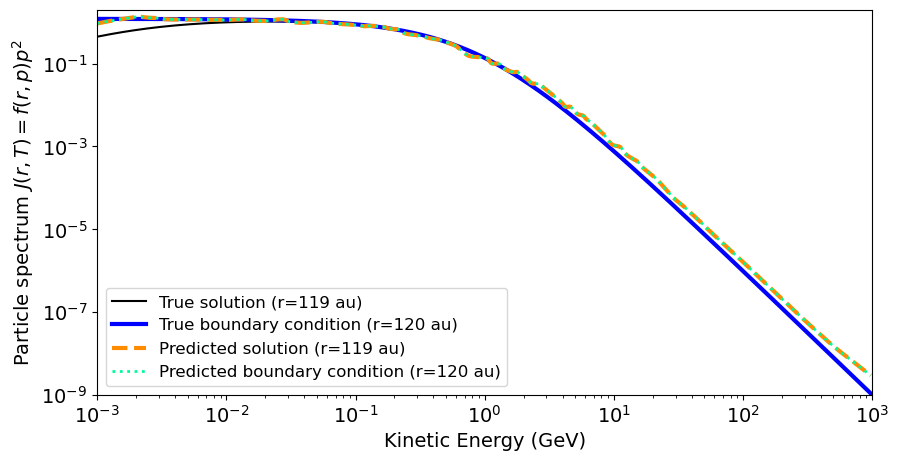

In [14]:
# Plot J(r, T)
fig, ax = plt.subplots(figsize=(10, 5))

ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6:.0f} au)', c='k')
ax.loglog(T, J[-1, :], label=f'True boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='blue', lw='3')
ax.loglog(T[:-1], np.expand_dims(final_predict[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6:.0f} au)', c='darkorange', lw='3', ls='--')
ax.loglog(T[:-1], np.expand_dims(final_predict[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted boundary condition (r={r[-1, 0]/150e6:.0f} au)', c='mediumspringgreen', lw='2', ls=':')

ax.set_xlabel("Kinetic Energy (GeV)")
ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(1e-9, 2e0)
ax.legend(prop={'size': 12})

plt.savefig('prediction.png')

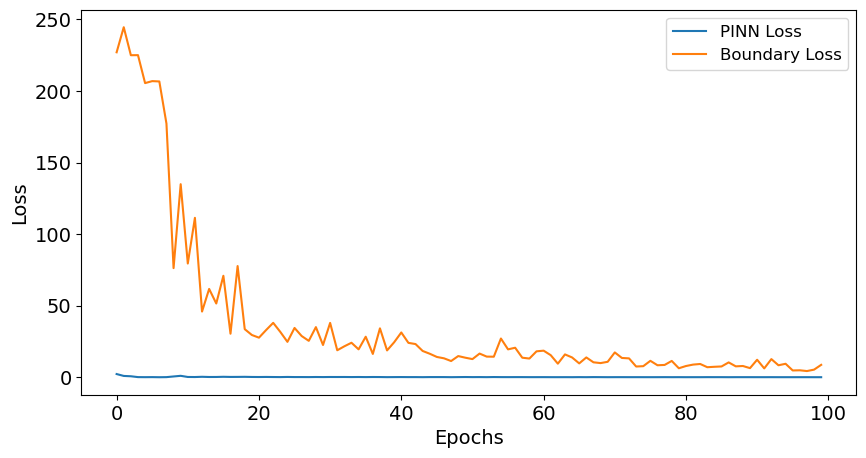

In [15]:
# Plot loss 
fig = plt.figure(figsize=(10, 5))

plt.plot(pinn_loss, label='PINN Loss')
plt.plot(boundary_loss, label='Boundary Loss')

# plt.ylim(0, 10)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(prop={'size': 12})
plt.savefig("loss.png")

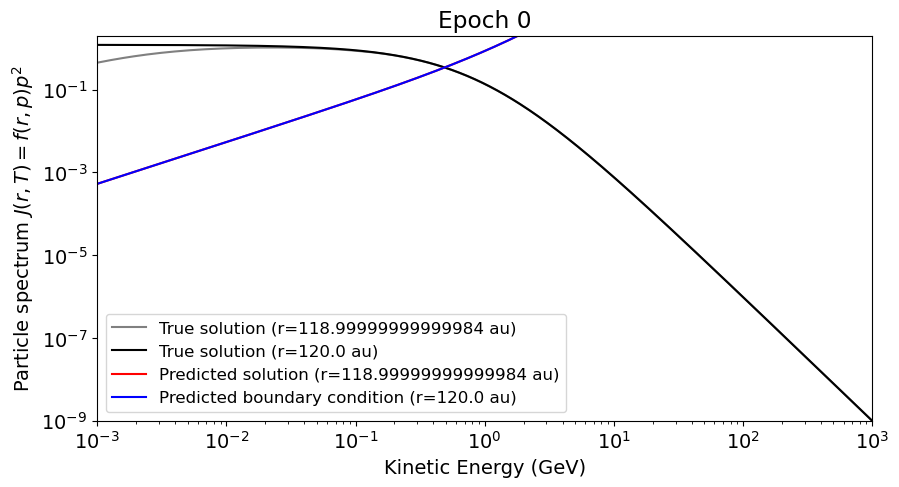

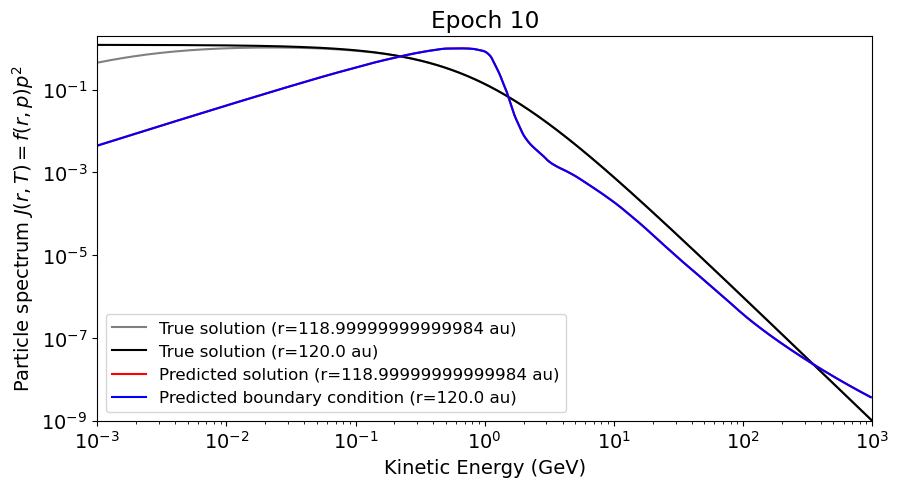

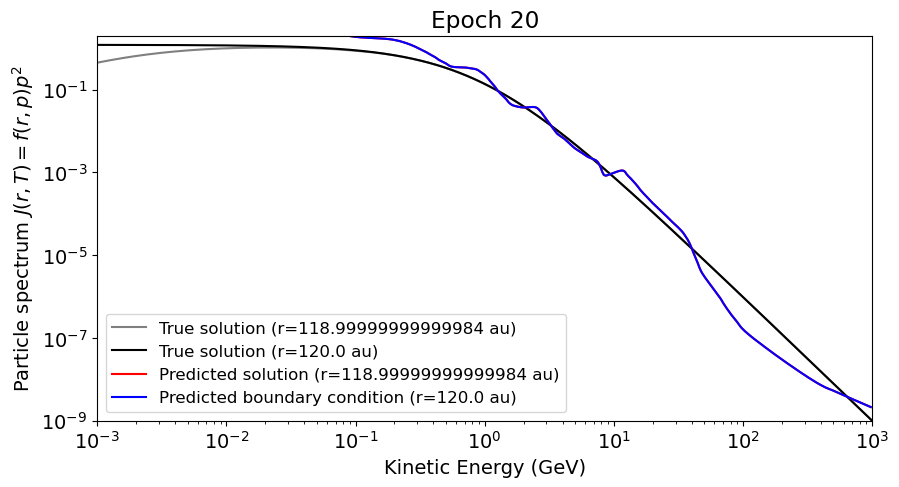

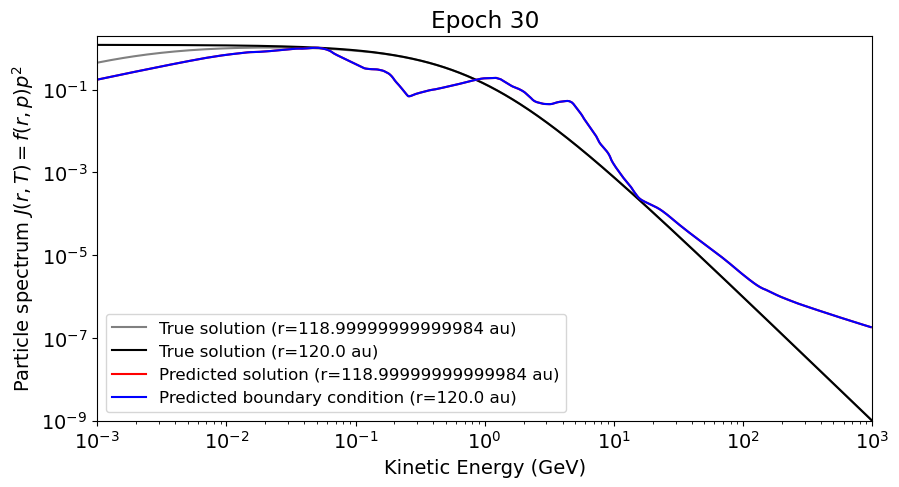

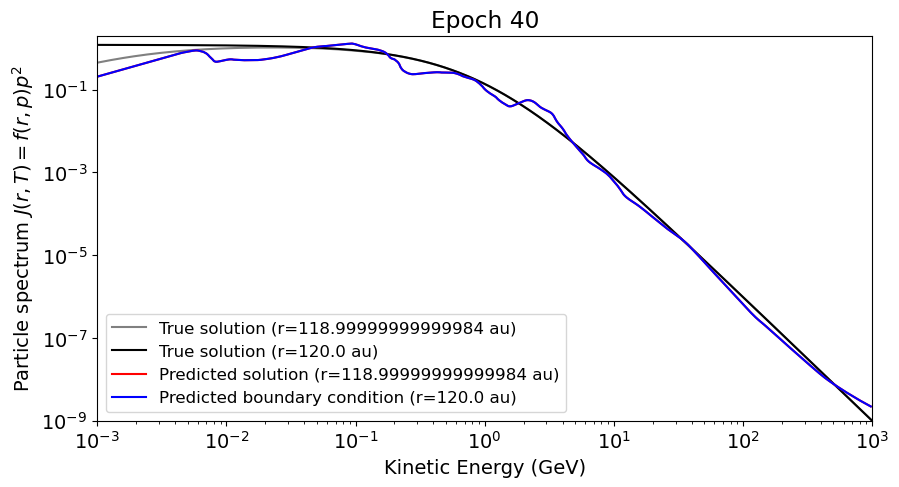

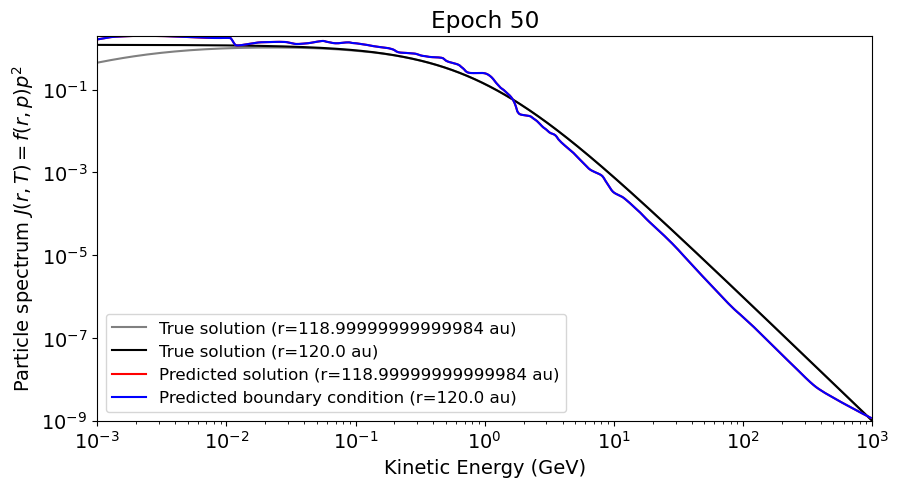

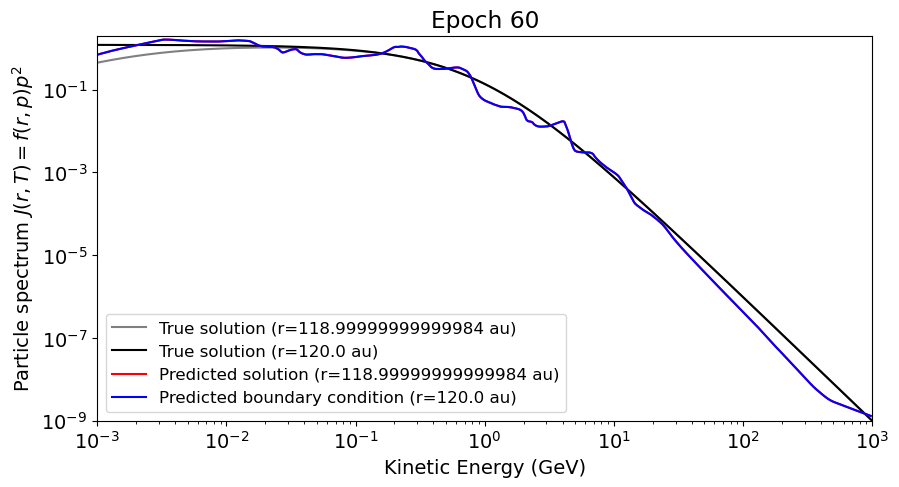

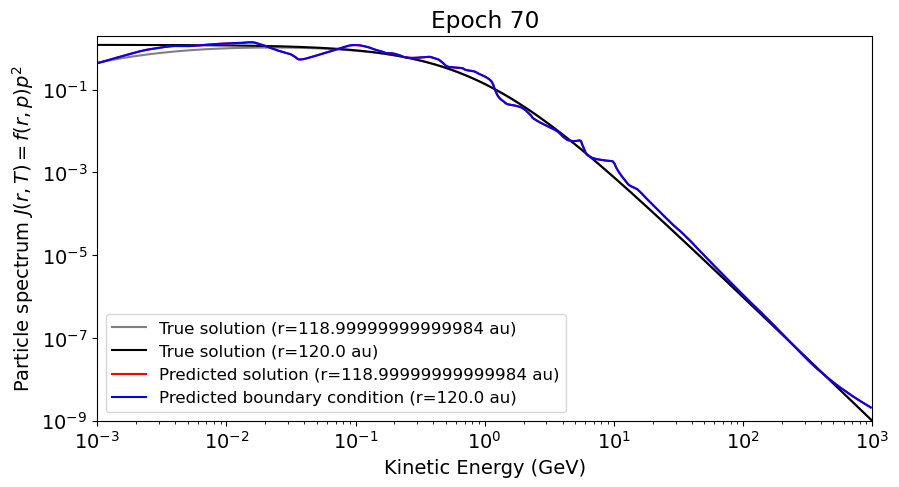

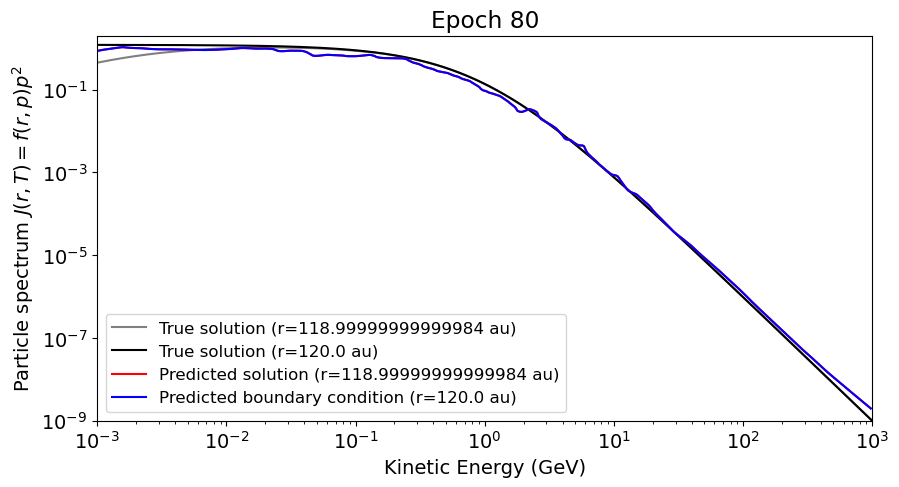

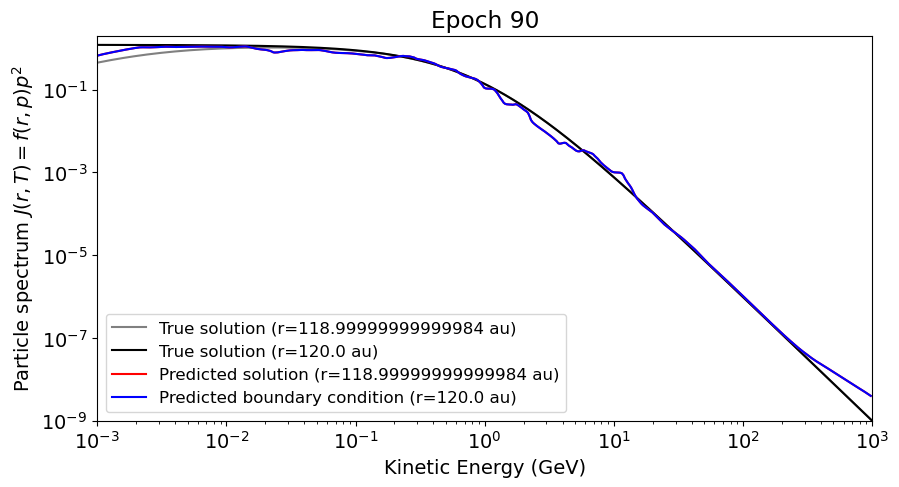

In [17]:
# Visualize J(r, T) over the epochs
for i in range(epochs):
    if (i%50 == 0):
        fig, ax = plt.subplots(figsize=(10, 5))
        
        ax.set_title("Epoch " + str(i))
        ax.set_xlabel("Kinetic Energy (GeV)")
        ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
        ax.set_xlim(1e-3, 1e3)
        ax.set_ylim(1e-9, 2e0)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
    
        ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6} au)', c='gray')
        ax.loglog(T, J[-1, :], label=f'True solution (r={r[-1, 0]/150e6} au)', c='k')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6} au)', c='red')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted boundary condition (r={r[-1, 0]/150e6} au)', c='blue')
        
        ax.legend(prop={'size': 12})